# 다이소 화장품 시계열 EDA v3 - 재구매/신규구매 현황 분석

## 분석 목적
리뷰 데이터의 시계열 패턴을 통해 재구매와 신규구매 현황을 파악

## 데이터 범위
- **기간**: 2024년 1월 ~ 2026년 1월
- **분석 대상**: 제품별 리뷰 데이터

## 분석 목차
1. 데이터 로딩 및 기본 통계
2. 년별 재구매/신규구매 추이
3. 월별 재구매/신규구매 추이
4. 대분류 카테고리별 시계열 분석
5. 소분류 카테고리별 시계열 분석
6. 카테고리별 인기제품 시계열 분석
7. 신제품 출시 패턴 (첫 리뷰 기준)

## 0. 데이터 로딩 및 기본 통계

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 시각화 스타일
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Noto Sans KR'
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 로딩 완료")

라이브러리 로딩 완료


In [3]:
# 데이터 로딩
data_dir = '/Users/yu_seok/Documents/workspace/nbCamp/Project/Why-pi/data'

products_df = pd.read_parquet(f'{data_dir}/products_with_features.parquet')
reviews_df = pd.read_parquet(f'{data_dir}/reviews_with_features.parquet')

print(f"제품 데이터: {len(products_df):,}개")
print(f"리뷰 데이터: {len(reviews_df):,}개")

# 날짜 변환
reviews_df['date'] = pd.to_datetime(reviews_df['date'])

# 기간 확인
print(f"\n리뷰 기간: {reviews_df['date'].min()} ~ {reviews_df['date'].max()}")
print(f"분석 기간: 2024-01-01 ~ 2026-01-31")

# 분석 기간으로 필터링 (이미 되어있지만 확인)
reviews_df = reviews_df[
    (reviews_df['date'] >= '2024-01-01') &
    (reviews_df['date'] <= '2026-01-31')
].copy()

print(f"\n필터링 후 리뷰: {len(reviews_df):,}개")

제품 데이터: 868개
리뷰 데이터: 312,139개

리뷰 기간: 2024-01-01 00:00:00 ~ 2026-02-04 00:00:00
분석 기간: 2024-01-01 ~ 2026-01-31

필터링 후 리뷰: 309,866개


In [4]:
# 제품 정보 병합
reviews_with_product = reviews_df.merge(
    products_df[['product_code', 'category_1', 'category_2', 'engagement_score', 'price', 'brand']],
    on='product_code',
    how='left'
)

print("제품 정보 병합 완료")
print(f"\n재구매 리뷰: {reviews_with_product['is_reorder'].sum():,}개 ({reviews_with_product['is_reorder'].mean()*100:.2f}%)")
print(f"신규 구매 리뷰: {(~reviews_with_product['is_reorder']).sum():,}개 ({(~reviews_with_product['is_reorder']).mean()*100:.2f}%)")

제품 정보 병합 완료

재구매 리뷰: 94,480개 (30.30%)
신규 구매 리뷰: 217,328개 (69.70%)


## 1. 년별 재구매/신규구매 추이

**분석 목적**: 년도별 재구매와 신규구매의 비율 변화 파악

=== 년별 재구매/신규구매 현황 ===
        신규구매    재구매    총_리뷰   재구매율
year                              
2024   55111  29815   84926  35.11
2025  146518  59704  206222  28.95
2026   15699   4961   20660  24.01


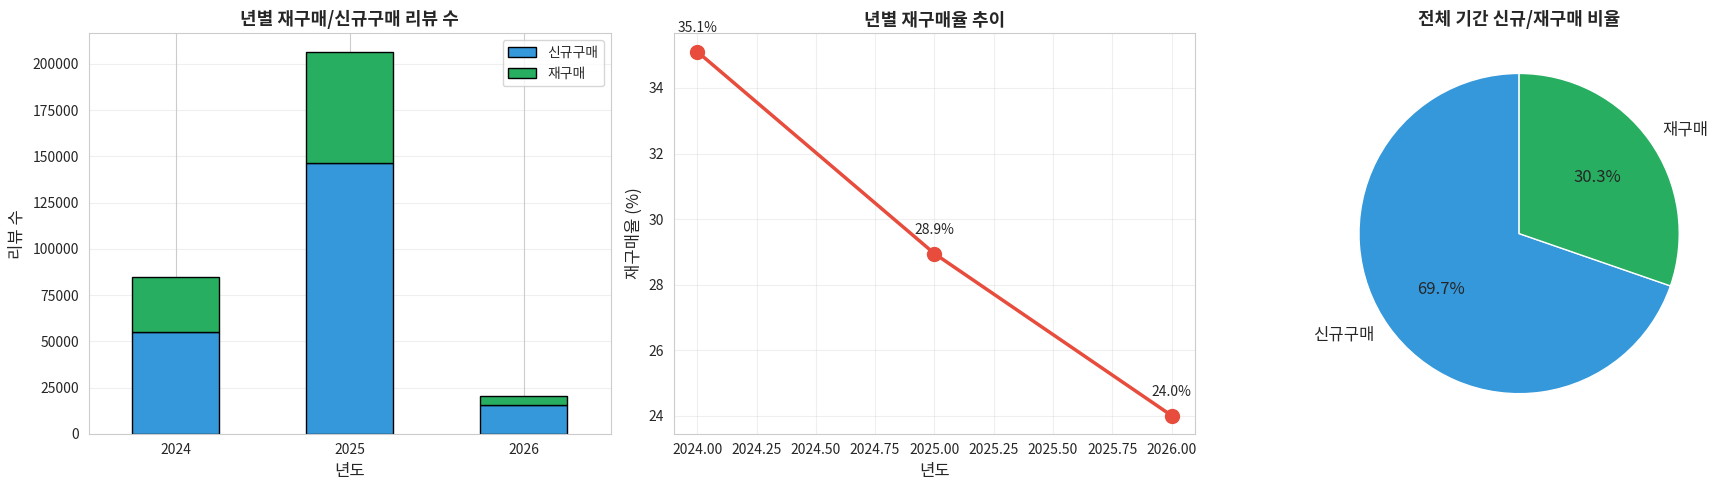

In [ ]:
# 년별 재구매/신규구매 집계
yearly_purchase_type = reviews_with_product.groupby(['year', 'is_reorder']).size().unstack(fill_value=0)
yearly_purchase_type.columns = ['신규구매', '재구매']

# 비율 계산
yearly_purchase_type['총_리뷰'] = yearly_purchase_type['신규구매'] + yearly_purchase_type['재구매']
yearly_purchase_type['재구매율'] = (yearly_purchase_type['재구매'] / yearly_purchase_type['총_리뷰'] * 100).round(2)

print("=== 년별 재구매/신규구매 현황 ===")
print(yearly_purchase_type)

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. 스택 바 차트
yearly_purchase_type[['신규구매', '재구매']].plot(kind='bar', stacked=True, ax=axes[0],
                                                  color=['#3498DB', '#27AE60'], edgecolor='black')
axes[0].set_xlabel('년도', fontsize=12)
axes[0].set_ylabel('리뷰 수', fontsize=12)
axes[0].set_title('년별 재구매/신규구매 리뷰 수', fontsize=13, fontweight='bold')
axes[0].legend(['신규구매', '재구매'])
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# 2. 재구매율 추이
axes[1].plot(yearly_purchase_type.index, yearly_purchase_type['재구매율'],
            marker='o', color='#E74C3C', linewidth=2.5, markersize=10)
axes[1].set_xlabel('년도', fontsize=12)
axes[1].set_ylabel('재구매율 (%)', fontsize=12)
axes[1].set_title('년별 재구매율 추이', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

for year, value in zip(yearly_purchase_type.index, yearly_purchase_type['재구매율']):
    axes[1].text(year, value + 0.5, f'{value:.1f}%', ha='center', va='bottom', fontsize=10)

# 3. 비율 파이 차트 (전체 기간)
total_new = yearly_purchase_type['신규구매'].sum()
total_reorder = yearly_purchase_type['재구매'].sum()

axes[2].pie([total_new, total_reorder], labels=['신규구매', '재구매'],
           autopct='%1.1f%%', colors=['#3498DB', '#27AE60'],
           startangle=90, textprops={'fontsize': 12})
axes[2].set_title('전체 기간 신규/재구매 비율', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

## 2. 월별 재구매/신규구매 추이

**분석 목적**: 월별 세밀한 추이 파악 및 계절성 분석

In [6]:
# 년-월 컬럼 생성
reviews_with_product['year_month'] = reviews_with_product['date'].dt.to_period('M')

# 월별 집계
monthly_purchase_type = reviews_with_product.groupby(['year_month', 'is_reorder']).size().unstack(fill_value=0)
monthly_purchase_type.columns = ['신규구매', '재구매']
monthly_purchase_type['총_리뷰'] = monthly_purchase_type['신규구매'] + monthly_purchase_type['재구매']
monthly_purchase_type['재구매율'] = (monthly_purchase_type['재구매'] / monthly_purchase_type['총_리뷰'] * 100).round(2)

print("=== 월별 재구매/신규구매 현황 (최근 12개월) ===")
print(monthly_purchase_type.tail(12))

=== 월별 재구매/신규구매 현황 (최근 12개월) ===
             신규구매   재구매   총_리뷰   재구매율
year_month                           
2025-02     11041  4000  15041  26.59
2025-03     14507  5582  20089  27.79
2025-04     13850  5884  19734  29.82
2025-05     13532  5754  19286  29.84
2025-06     10380  4628  15008  30.84
2025-07     11758  4970  16728  29.71
2025-08     11750  4972  16722  29.73
2025-09     11924  4889  16813  29.08
2025-10     10490  4355  14845  29.34
2025-11     11779  4890  16669  29.34
2025-12     13923  5232  19155  27.31
2026-01     15699  4961  20660  24.01


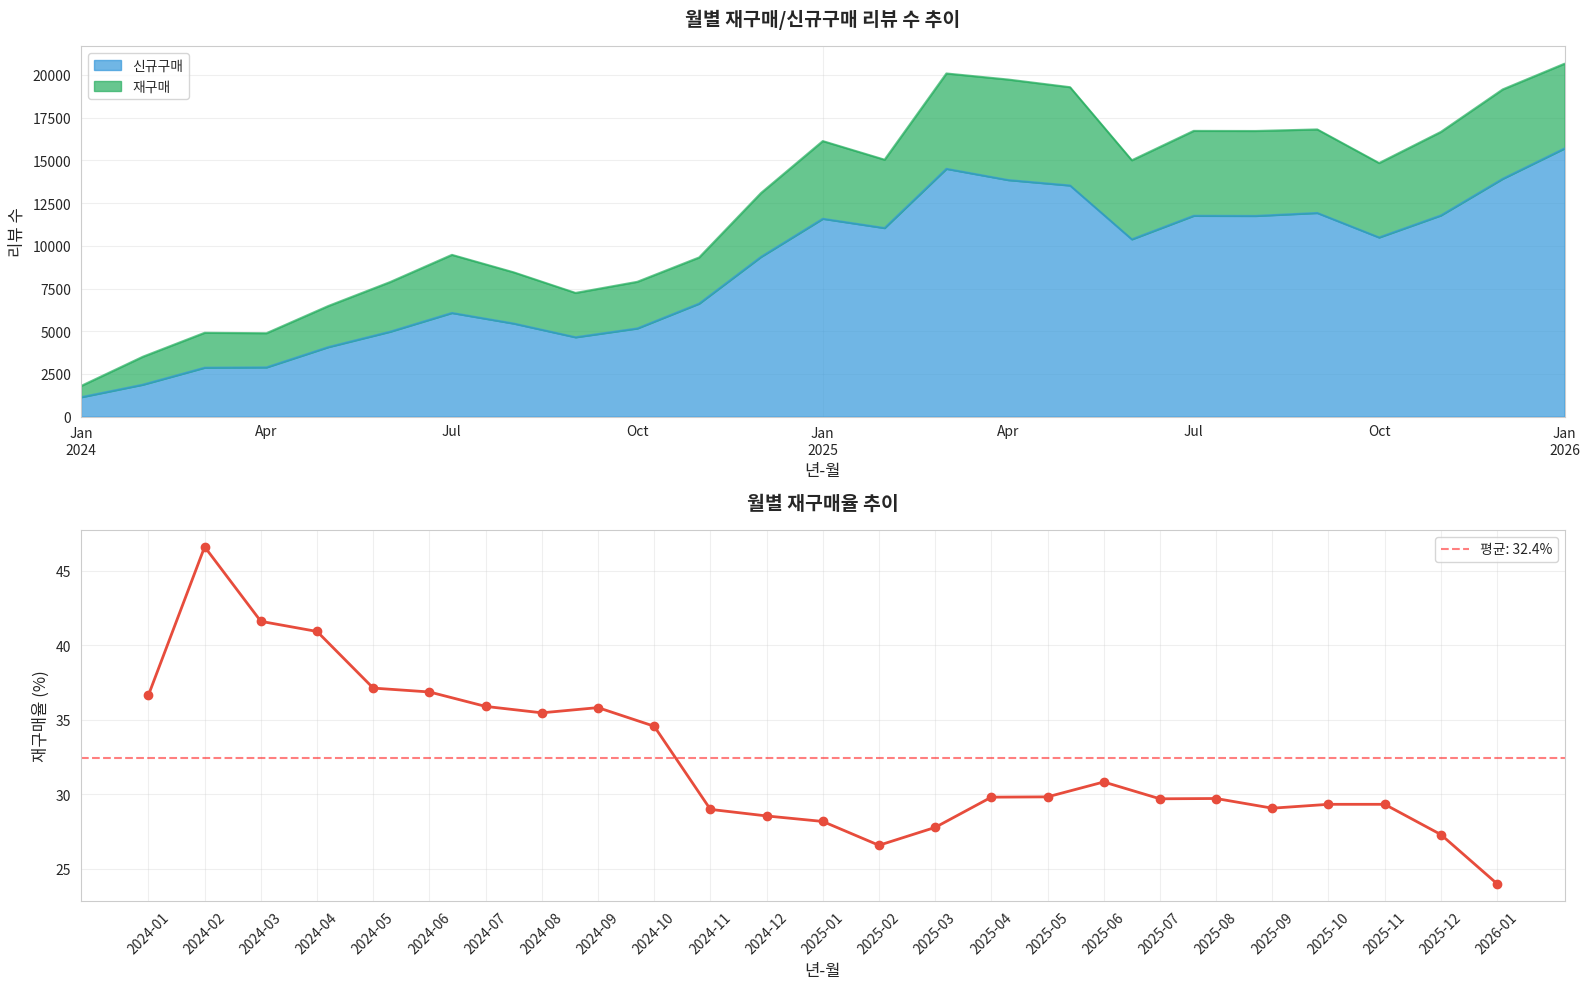

In [23]:
# 월별 시각화
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# 1. 월별 리뷰 수 추이
monthly_purchase_type[['신규구매', '재구매']].plot(kind='area', stacked=True, ax=axes[0],
                                                  color=['#3498DB', '#27AE60'], alpha=0.7)
axes[0].set_xlabel('년-월', fontsize=12)
axes[0].set_ylabel('리뷰 수', fontsize=12)
axes[0].set_title('월별 재구매/신규구매 리뷰 수 추이', fontsize=14, fontweight='bold', pad=15)
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# 2. 월별 재구매율 추이
axes[1].plot(monthly_purchase_type.index.astype(str), monthly_purchase_type['재구매율'],
            marker='o', color='#E74C3C', linewidth=2, markersize=6)
axes[1].axhline(y=monthly_purchase_type['재구매율'].mean(), color='red', linestyle='--',
               linewidth=1.5, alpha=0.5, label=f'평균: {monthly_purchase_type["재구매율"].mean():.1f}%')
axes[1].set_xlabel('년-월', fontsize=12)
axes[1].set_ylabel('재구매율 (%)', fontsize=12)
axes[1].set_title('월별 재구매율 추이', fontsize=14, fontweight='bold', pad=15)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 3. 대분류 카테고리별 시계열 분석

**분석 목적**: category_1 (대분류) 기준 시계열 패턴 분석

In [8]:
# 대분류 카테고리별 월별 집계
category1_monthly = reviews_with_product.groupby(['year_month', 'category_1', 'is_reorder']).size().unstack(fill_value=0)
category1_monthly.columns = ['신규구매', '재구매']
category1_monthly = category1_monthly.reset_index()

# 재구매율 계산
category1_monthly['총_리뷰'] = category1_monthly['신규구매'] + category1_monthly['재구매']
category1_monthly['재구매율'] = (category1_monthly['재구매'] / category1_monthly['총_리뷰'] * 100).round(2)

print("=== 대분류 카테고리 목록 ===")
print(reviews_with_product['category_1'].value_counts())

=== 대분류 카테고리 목록 ===
category_1
스킨케어    213524
메이크업     92282
맨케어       6002
Name: count, dtype: int64


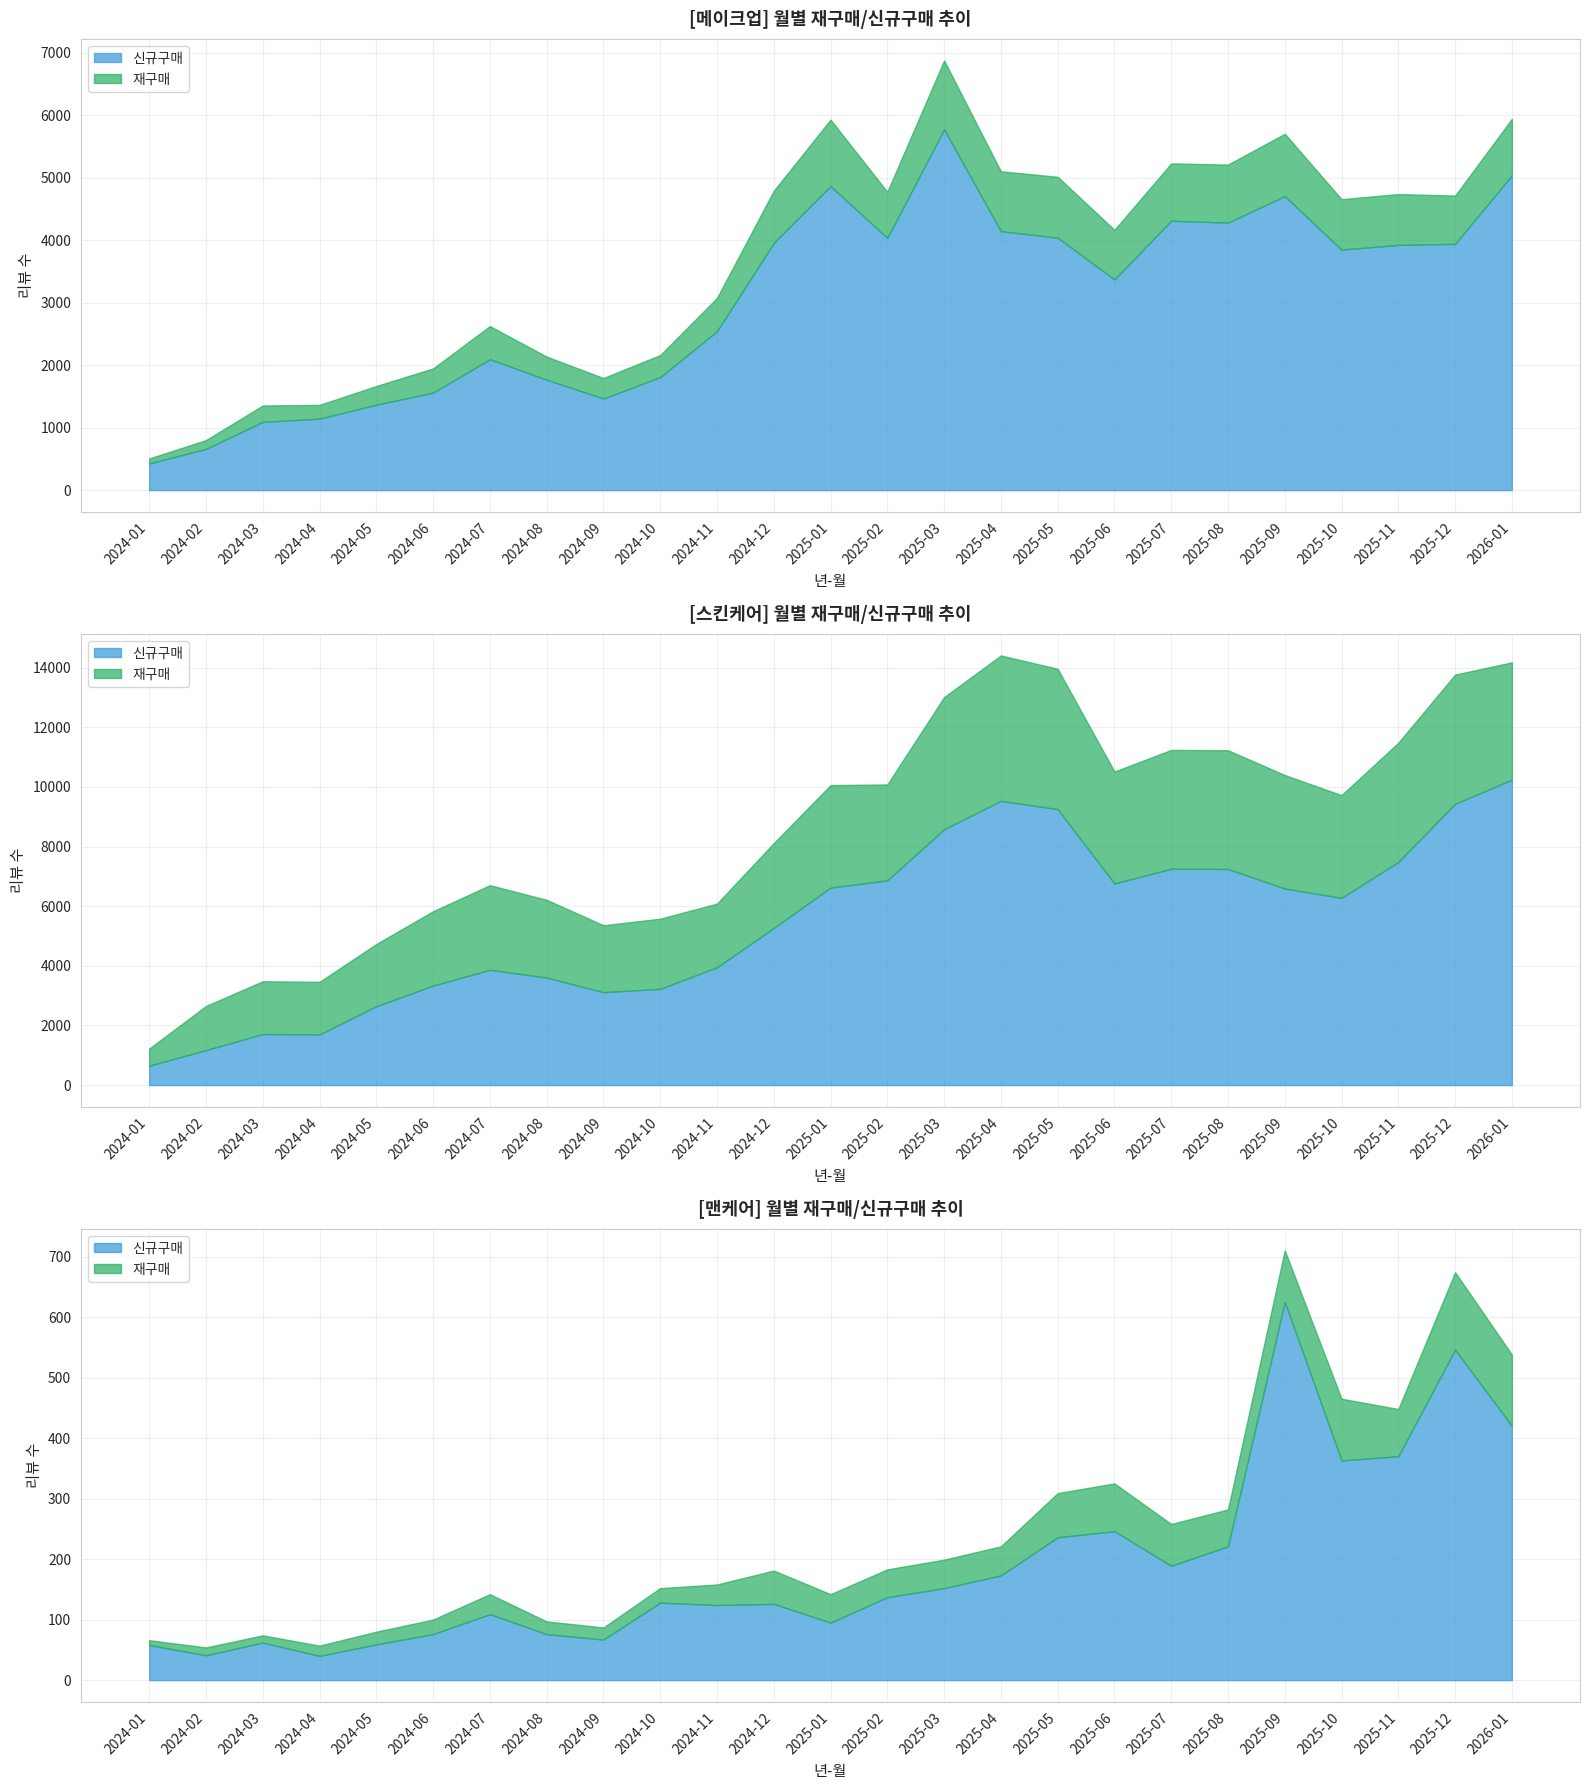

In [ ]:
# 대분류 카테고리별 시각화
categories_1 = reviews_with_product['category_1'].unique()

fig, axes = plt.subplots(len(categories_1), 1, figsize=(16, 6 * len(categories_1)))

if len(categories_1) == 1:
    axes = [axes]

for idx, cat in enumerate(categories_1):
    cat_data = category1_monthly[category1_monthly['category_1'] == cat]

    # 스택 영역 차트
    ax = axes[idx]
    ax.fill_between(range(len(cat_data)), 0, cat_data['신규구매'].values,
                    label='신규구매', color='#3498DB', alpha=0.7)
    ax.fill_between(range(len(cat_data)), cat_data['신규구매'].values,
                    cat_data['총_리뷰'].values,
                    label='재구매', color='#27AE60', alpha=0.7)

    ax.set_xticks(range(len(cat_data)))
    ax.set_xticklabels(cat_data['year_month'].astype(str), rotation=45, ha='right')
    ax.set_xlabel('년-월', fontsize=11)
    ax.set_ylabel('리뷰 수', fontsize=11)
    ax.set_title(f'[{cat}] 월별 재구매/신규구매 추이', fontsize=13, fontweight='bold', pad=10)
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== 대분류 카테고리별 재구매율 ===
              신규구매    재구매    총_리뷰   재구매율
category_1                              
스킨케어        136421  77103  213524  36.11
맨케어           4739   1263    6002  21.04
메이크업         76168  16114   92282  17.46


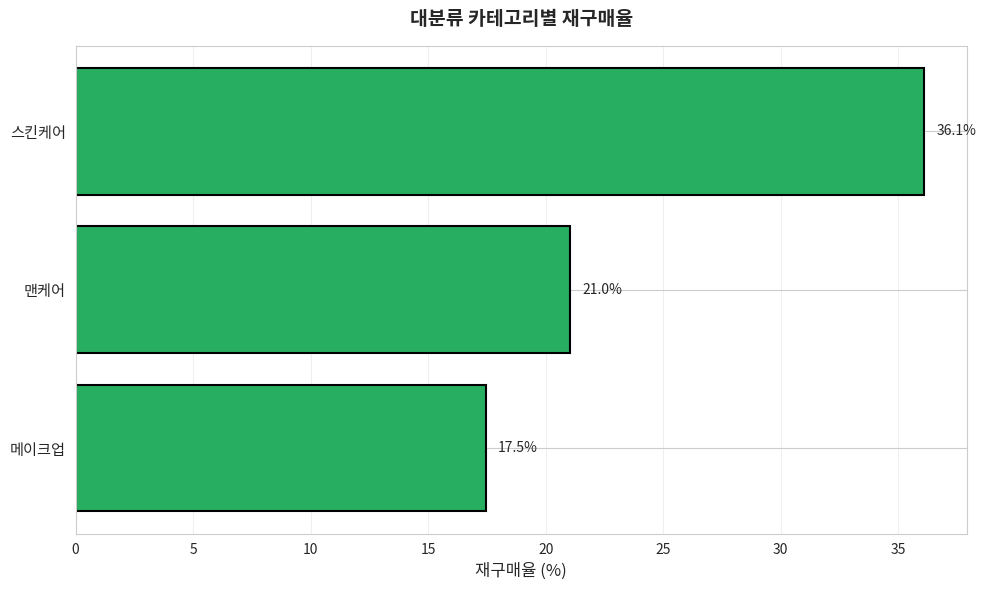

In [10]:
# 대분류 카테고리별 재구매율 비교
category1_reorder_rate = category1_monthly.groupby('category_1').agg({
    '신규구매': 'sum',
    '재구매': 'sum',
    '총_리뷰': 'sum'
})
category1_reorder_rate['재구매율'] = (
    category1_reorder_rate['재구매'] / category1_reorder_rate['총_리뷰'] * 100
).round(2)

print("=== 대분류 카테고리별 재구매율 ===")
print(category1_reorder_rate.sort_values('재구매율', ascending=False))

# 시각화
fig, ax = plt.subplots(figsize=(10, 6))

category1_reorder_rate_sorted = category1_reorder_rate.sort_values('재구매율', ascending=True)
ax.barh(range(len(category1_reorder_rate_sorted)), category1_reorder_rate_sorted['재구매율'].values,
       color='#27AE60', edgecolor='black', linewidth=1.5)
ax.set_yticks(range(len(category1_reorder_rate_sorted)))
ax.set_yticklabels(category1_reorder_rate_sorted.index, fontsize=11)
ax.set_xlabel('재구매율 (%)', fontsize=12)
ax.set_title('대분류 카테고리별 재구매율', fontsize=14, fontweight='bold', pad=15)
ax.grid(axis='x', alpha=0.3)

for i, v in enumerate(category1_reorder_rate_sorted['재구매율'].values):
    ax.text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## 4. 소분류 카테고리별 시계열 분석

**분석 목적**: category_2 (소분류) 기준 상위 카테고리 시계열 패턴 분석

In [11]:
# 소분류 카테고리별 월별 집계
category2_monthly = reviews_with_product.groupby(['year_month', 'category_2', 'is_reorder']).size().unstack(fill_value=0)
category2_monthly.columns = ['신규구매', '재구매']
category2_monthly = category2_monthly.reset_index()
category2_monthly['총_리뷰'] = category2_monthly['신규구매'] + category2_monthly['재구매']
category2_monthly['재구매율'] = (category2_monthly['재구매'] / category2_monthly['총_리뷰'] * 100).round(2)

# 상위 10개 카테고리 선정
top_10_categories = reviews_with_product['category_2'].value_counts().head(10).index

print("=== 분석 대상 상위 10개 소분류 카테고리 ===")
for i, cat in enumerate(top_10_categories, 1):
    count = len(reviews_with_product[reviews_with_product['category_2'] == cat])
    print(f"{i}. {cat}: {count:,}개 리뷰")

=== 분석 대상 상위 10개 소분류 카테고리 ===
1. 기초스킨케어: 151,263개 리뷰
2. 팩/마스크: 32,421개 리뷰
3. 립메이크업: 27,872개 리뷰
4. 베이스메이크업: 27,423개 리뷰
5. 아이메이크업: 24,194개 리뷰
6. 치크/하이라이터: 12,793개 리뷰
7. 클렌징/필링: 11,964개 리뷰
8. 자외선차단제: 11,851개 리뷰
9. 립케어: 6,025개 리뷰
10. 남성스킨케어: 2,868개 리뷰



총 14개 소분류 카테고리 분석


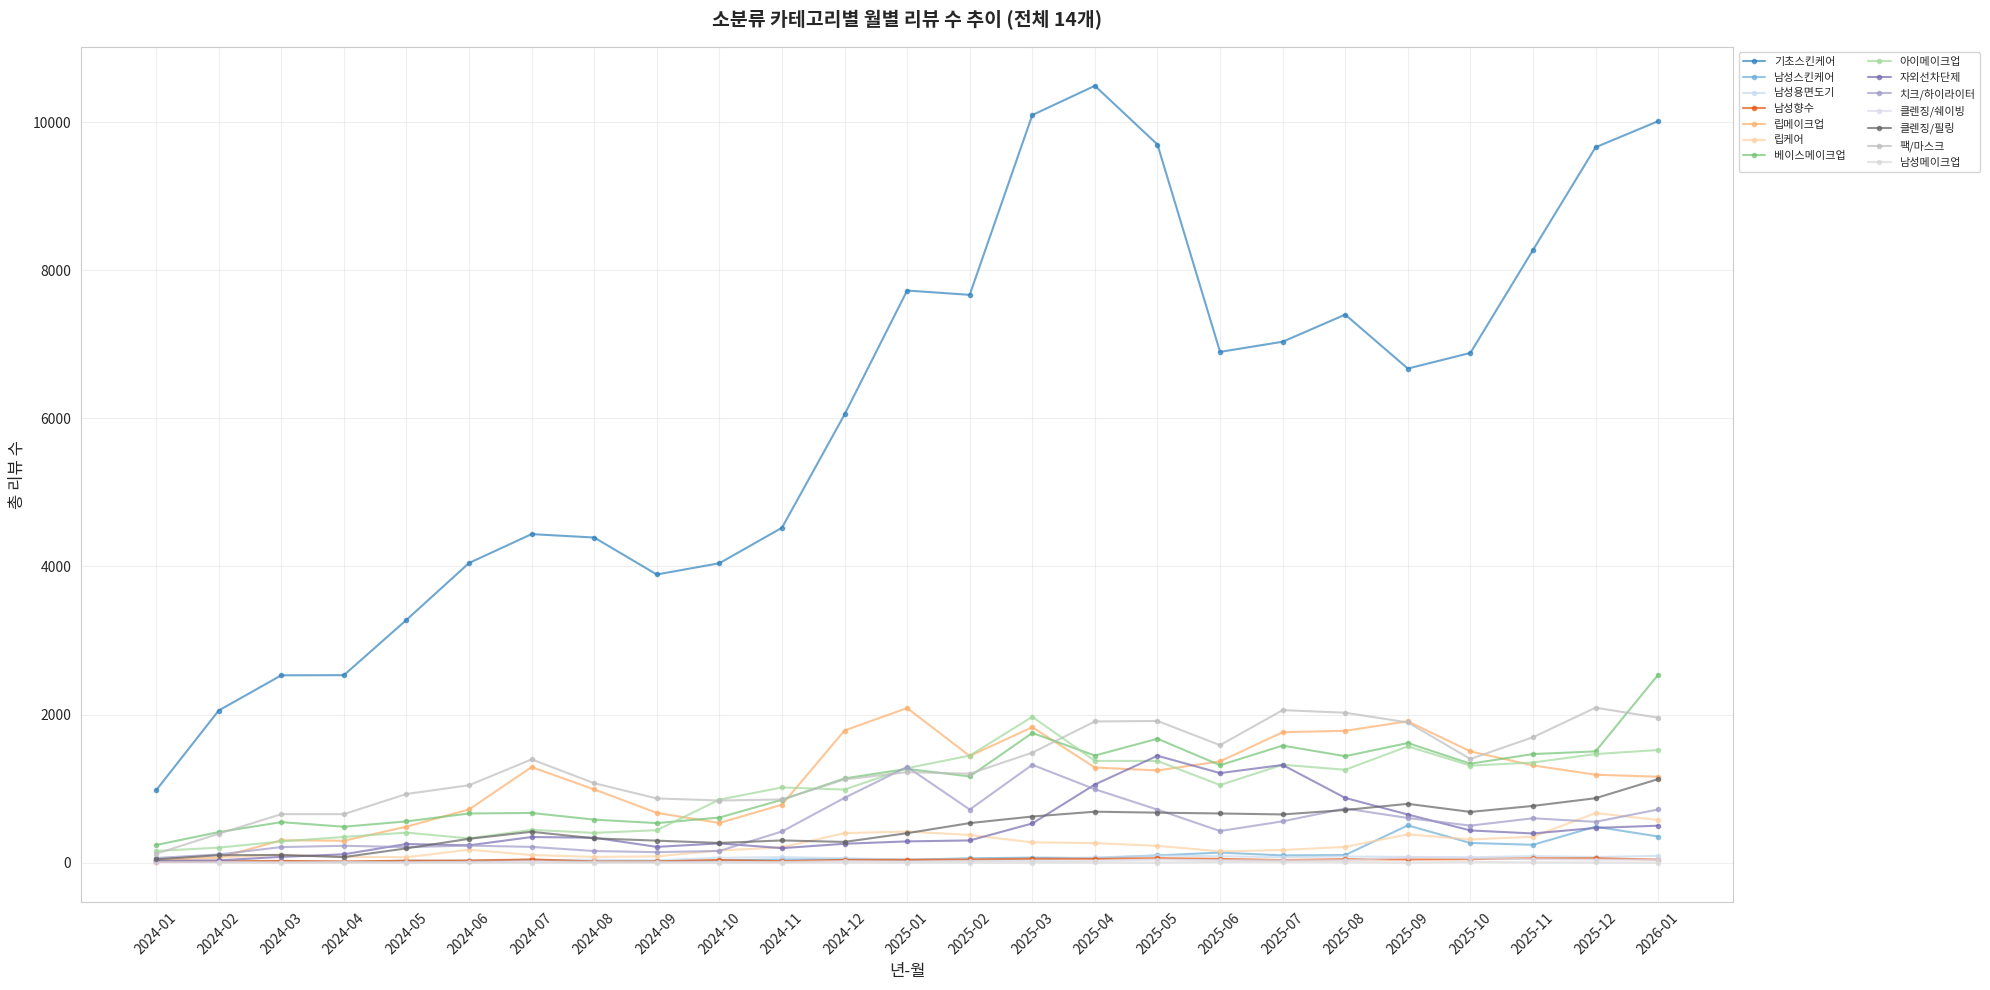

In [20]:
# 전체 소분류 카테고리 월별 리뷰 수 추이
all_categories = category2_monthly['category_2'].unique()
print(f"\n총 {len(all_categories)}개 소분류 카테고리 분석")

fig, ax = plt.subplots(figsize=(20, 10))

# 색상 팔레트 생성 (카테고리 수만큼)
colors = plt.cm.tab20c(np.linspace(0, 1, len(all_categories)))

for i, cat in enumerate(all_categories):
    cat_data = category2_monthly[category2_monthly['category_2'] == cat]
    ax.plot(cat_data['year_month'].astype(str), cat_data['총_리뷰'],
           marker='o', linewidth=1.5, label=cat, markersize=3, 
           color=colors[i], alpha=0.7)

ax.set_xlabel('년-월', fontsize=12)
ax.set_ylabel('총 리뷰 수', fontsize=12)
ax.set_title(f'소분류 카테고리별 월별 리뷰 수 추이 (전체 {len(all_categories)}개)', 
            fontsize=14, fontweight='bold', pad=15)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8, ncol=2)
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

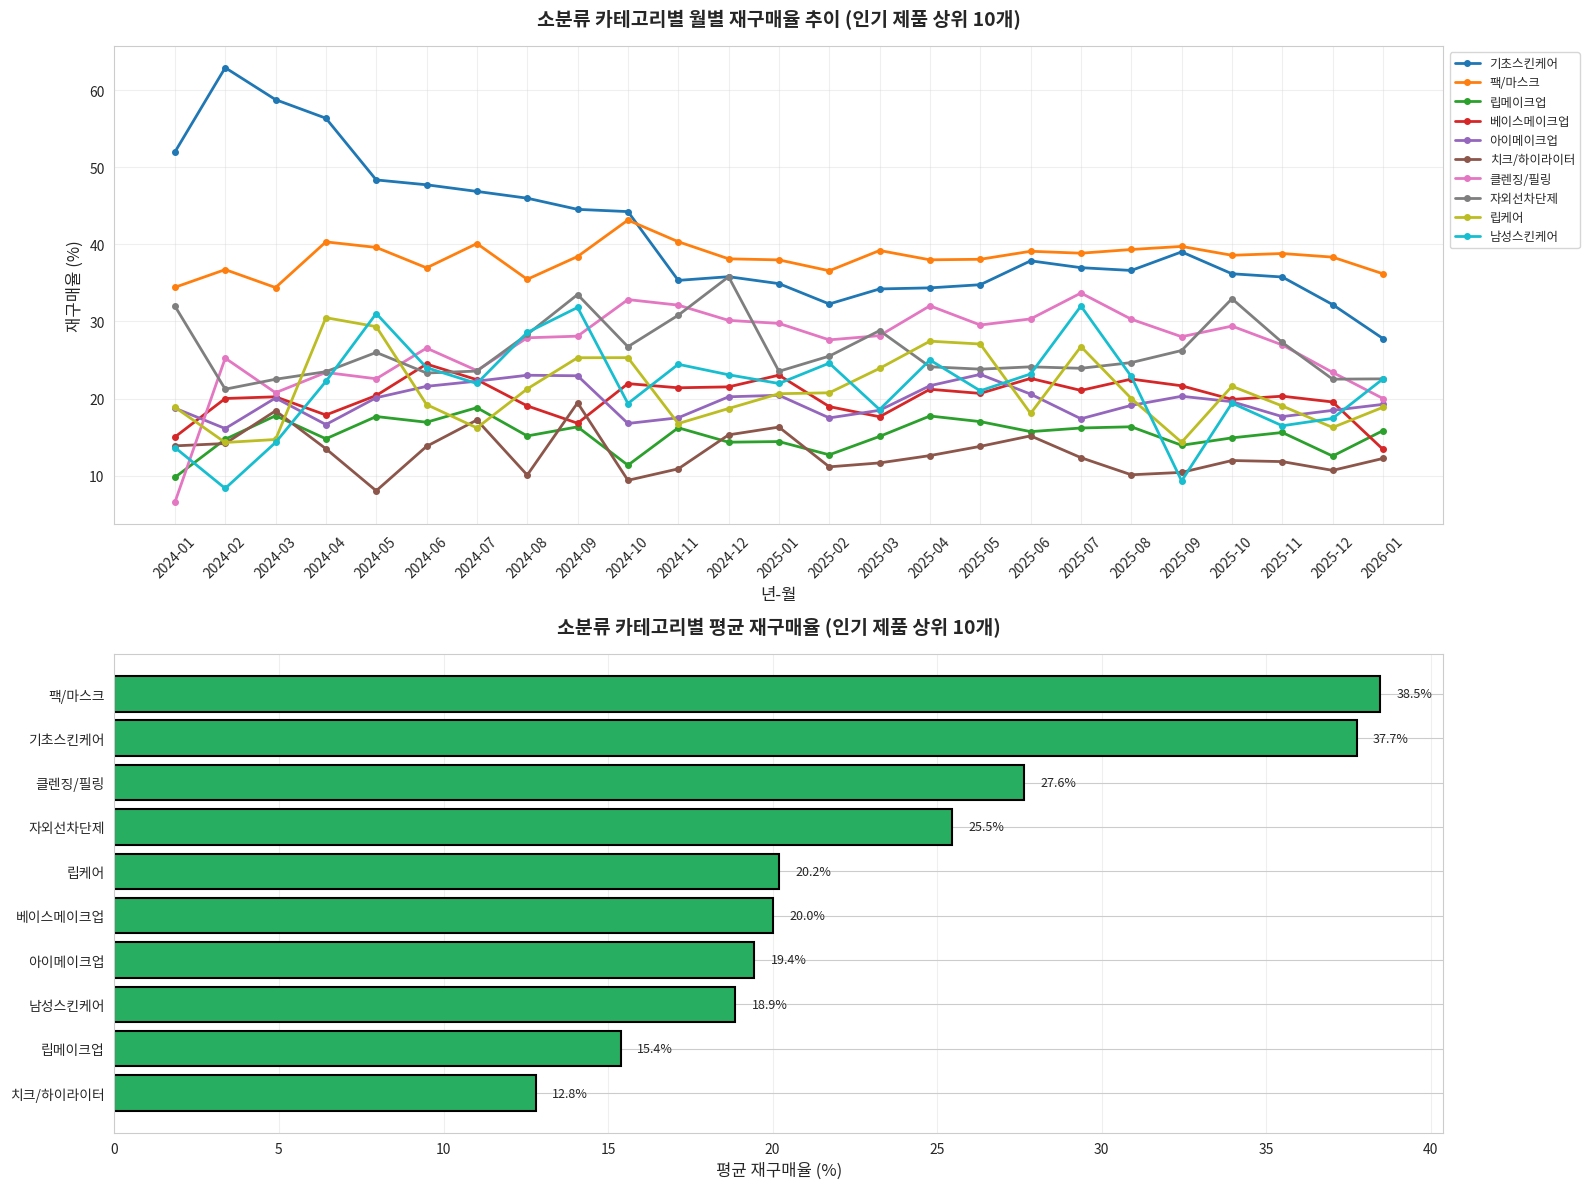

In [13]:
# 상위 10개 카테고리 재구매율 비교
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# 1. 카테고리별 재구매율 추이
for cat in top_10_categories:
    cat_data = category2_monthly[category2_monthly['category_2'] == cat]
    axes[0].plot(cat_data['year_month'].astype(str), cat_data['재구매율'],
                marker='o', linewidth=2, label=cat, markersize=4)

axes[0].set_xlabel('년-월', fontsize=12)
axes[0].set_ylabel('재구매율 (%)', fontsize=12)
axes[0].set_title('소분류 카테고리별 월별 재구매율 추이 (인기 제품 상위 10개)', fontsize=14, fontweight='bold', pad=15)
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# 2. 평균 재구매율 막대 차트
category2_avg_reorder = category2_monthly.groupby('category_2').agg({
    '신규구매': 'sum',
    '재구매': 'sum'
})
category2_avg_reorder['재구매율'] = (
    category2_avg_reorder['재구매'] / (category2_avg_reorder['신규구매'] + category2_avg_reorder['재구매']) * 100
)

top_10_avg = category2_avg_reorder.loc[top_10_categories].sort_values('재구매율', ascending=True)

axes[1].barh(range(len(top_10_avg)), top_10_avg['재구매율'].values,
            color='#27AE60', edgecolor='black', linewidth=1.5)
axes[1].set_yticks(range(len(top_10_avg)))
axes[1].set_yticklabels(top_10_avg.index, fontsize=10)
axes[1].set_xlabel('평균 재구매율 (%)', fontsize=12)
axes[1].set_title('소분류 카테고리별 평균 재구매율 (인기 제품 상위 10개)', fontsize=14, fontweight='bold', pad=15)
axes[1].grid(axis='x', alpha=0.3)

for i, v in enumerate(top_10_avg['재구매율'].values):
    axes[1].text(v + 0.5, i, f'{v:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 5. 카테고리별 인기제품 시계열 분석

**분석 목적**: engagement_score 상위 제품의 시계열 패턴 분석

In [14]:
# 카테고리별 상위 3개 인기제품 선정
top_products_by_category = {}

for cat in top_10_categories:
    cat_products = products_df[products_df['category_2'] == cat].nlargest(3, 'engagement_score')
    top_products_by_category[cat] = cat_products['product_code'].tolist()

print("=== 카테고리별 상위 3개 인기제품 ===")
for cat, products in top_products_by_category.items():
    print(f"\n[{cat}]")
    for product_code in products:
        product_info = products_df[products_df['product_code'] == product_code].iloc[0]
        print(f"  - {product_info['name']} (engagement: {product_info['engagement_score']:.1f})")

=== 카테고리별 상위 3개 인기제품 ===

[기초스킨케어]
  - VT 리들샷 100 페이셜 부스팅 퍼스트 앰플 2ml*6개입 (engagement: 6998.3)
  - VT 리들샷 300 페이셜 부스팅 퍼스트 앰플 2ml*6개입 (engagement: 6990.5)
  - 본셉 비타씨 동결 건조 더블샷 앰플 키트 (engagement: 5040.1)

[팩/마스크]
  - 에그캡슐팩 (engagement: 3395.9)
  - VT 시카 슬리핑 마스크 4 ml 6개입 (engagement: 3379.1)
  - 시카 카밍 토너 패드 100매입 (engagement: 3237.4)

[립메이크업]
  - 손앤박 아티 스프레드 컬러 밤(03 멜로우) (engagement: 2350.9)
  - 손앤박 아티 스프레드 컬러 밤(01 선셋) (engagement: 2129.8)
  - [03 로즈티커] 본셉 립 타투 스티커 (engagement: 1903.4)

[베이스메이크업]
  - 입큰 퍼스널 톤 코렉팅 블러 팩트 5.5 g(라벤더) (engagement: 3548.4)
  - 클라뷰 밸런싱 포어밤 프라이머 10 ml (engagement: 2440.8)
  - 태그 벨벳 세팅 픽서 100 ml (engagement: 2157.2)

[아이메이크업]
  - 태그 슬림브로우펜슬(2호_애쉬브라운) (engagement: 2388.4)
  - 더봄 애교살＆트임 펜슬 (음영 브라운) (engagement: 2234.8)
  - 더봄 애교살＆트임 펜슬(볼륨베이지) (engagement: 2068.6)

[치크/하이라이터]
  - 밀크터치 디어씽 블러리 이펙트 스무드 터치팟 뮤트메모리 (engagement: 1532.5)
  - 태그 듀얼 멀티 쉐딩 9.4g 모노 쿨 (engagement: 1290.3)
  - 태그 무드블러쉬빔(2호_페어모브) 9 g (engagement: 1230.3)

[클렌징/필링]
  - 메디필 엑스트라 슈퍼 9 플러스 2.0 피지 클리너 5

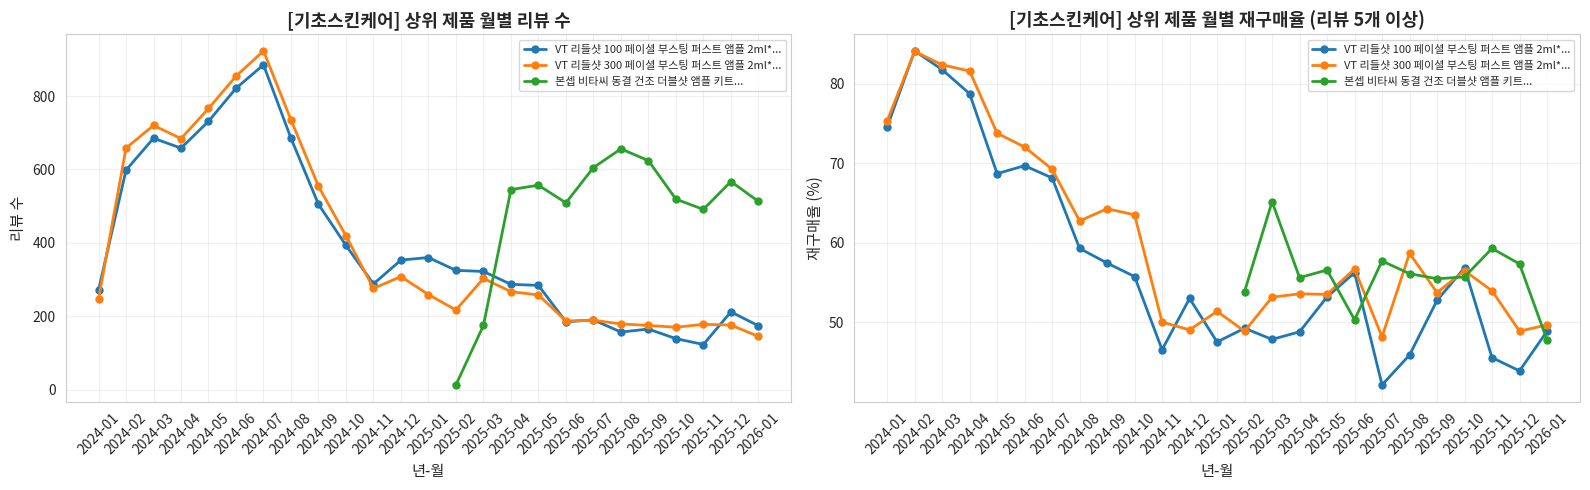

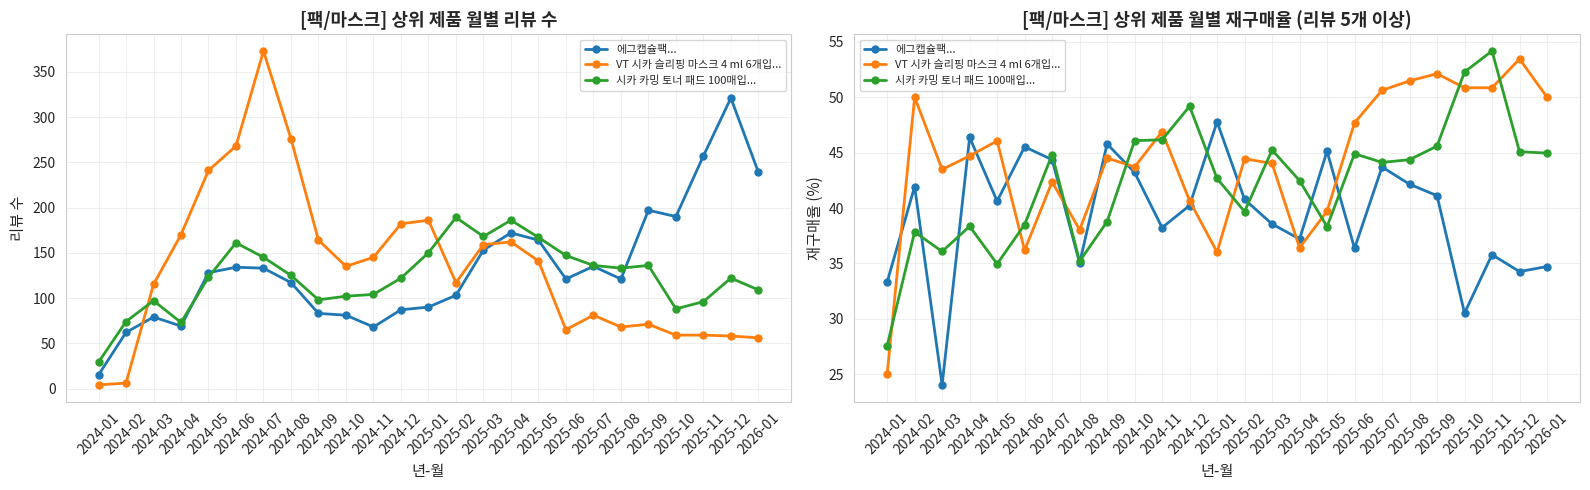

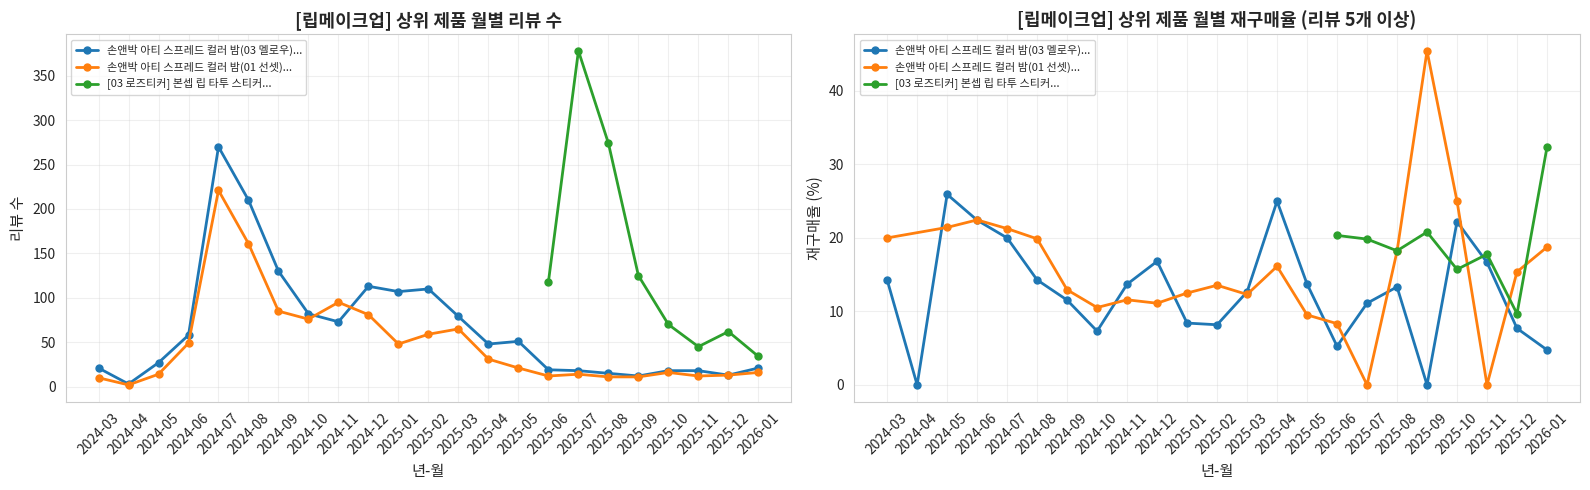

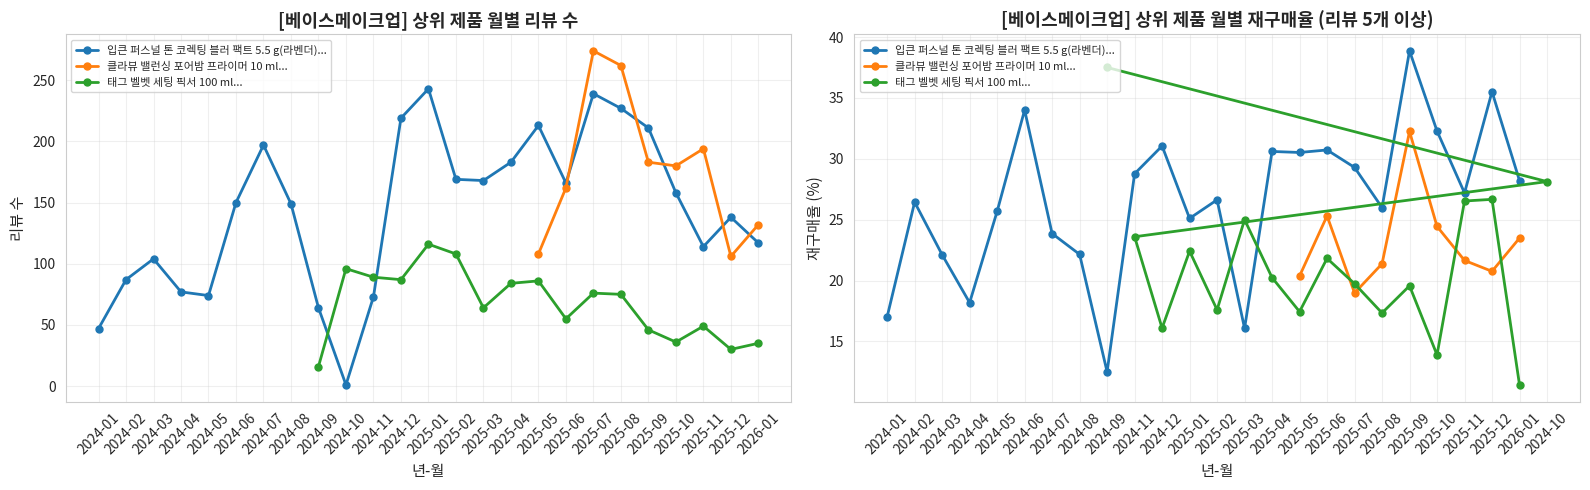

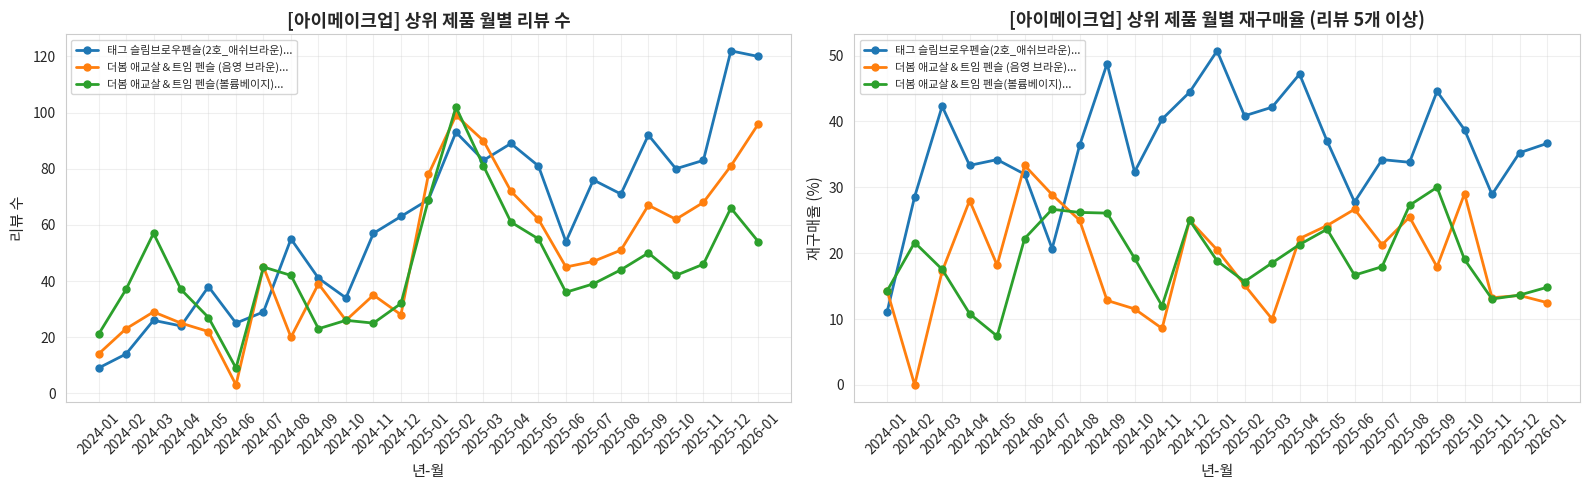

In [15]:
# 각 카테고리 상위 제품들의 월별 리뷰 추이
for cat in top_10_categories[:5]:  # 상위 5개 카테고리만
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    product_codes = top_products_by_category[cat]

    # 1. 월별 리뷰 수 추이
    for product_code in product_codes:
        product_name = products_df[products_df['product_code'] == product_code]['name'].iloc[0]
        product_reviews = reviews_with_product[reviews_with_product['product_code'] == product_code]

        monthly_count = product_reviews.groupby('year_month').size()

        axes[0].plot(monthly_count.index.astype(str), monthly_count.values,
                    marker='o', linewidth=2, label=product_name[:30] + '...', markersize=5)

    axes[0].set_xlabel('년-월', fontsize=11)
    axes[0].set_ylabel('리뷰 수', fontsize=11)
    axes[0].set_title(f'[{cat}] 상위 제품 월별 리뷰 수', fontsize=13, fontweight='bold')
    axes[0].legend(fontsize=8)
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)

    # 2. 월별 재구매율 추이
    for product_code in product_codes:
        product_name = products_df[products_df['product_code'] == product_code]['name'].iloc[0]
        product_reviews = reviews_with_product[reviews_with_product['product_code'] == product_code]

        monthly_reorder = product_reviews.groupby('year_month')['is_reorder'].agg(['sum', 'count'])
        monthly_reorder['재구매율'] = (monthly_reorder['sum'] / monthly_reorder['count'] * 100)

        # 리뷰가 5개 이상인 월만 표시
        monthly_reorder_filtered = monthly_reorder[monthly_reorder['count'] >= 3]

        if len(monthly_reorder_filtered) > 0:
            axes[1].plot(monthly_reorder_filtered.index.astype(str), monthly_reorder_filtered['재구매율'].values,
                        marker='o', linewidth=2, label=product_name[:30] + '...', markersize=5)

    axes[1].set_xlabel('년-월', fontsize=11)
    axes[1].set_ylabel('재구매율 (%)', fontsize=11)
    axes[1].set_title(f'[{cat}] 상위 제품 월별 재구매율 (리뷰 5개 이상)', fontsize=13, fontweight='bold')
    axes[1].legend(fontsize=8)
    axes[1].grid(True, alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

## 6. 신제품 출시 패턴 (첫 리뷰 기준)

**분석 목적**: 제품의 첫 리뷰 시점을 기준으로 신제품 출시 패턴 분석

In [16]:
# 제품별 첫 리뷰 날짜
product_first_review = reviews_with_product.groupby('product_code')['date'].min().reset_index()
product_first_review.columns = ['product_code', 'first_review_date']

# 제품 정보 병합
product_first_review = product_first_review.merge(
    products_df[['product_code', 'name', 'category_1', 'category_2', 'brand', 'engagement_score']],
    on='product_code',
    how='left'
)

# 년-월 추출
product_first_review['first_review_ym'] = pd.to_datetime(product_first_review['first_review_date']).dt.to_period('M')

print("=== 제품별 첫 리뷰 날짜 통계 ===")
print(f"전체 제품 수: {len(product_first_review):,}개")
print(f"첫 리뷰 기간: {product_first_review['first_review_date'].min()} ~ {product_first_review['first_review_date'].max()}")
print(f"\n월별 신제품 출시 현황 (첫 리뷰 기준):")
print(product_first_review['first_review_ym'].value_counts().sort_index())

=== 제품별 첫 리뷰 날짜 통계 ===
전체 제품 수: 857개
첫 리뷰 기간: 2024-01-01 00:00:00 ~ 2026-01-12 00:00:00

월별 신제품 출시 현황 (첫 리뷰 기준):
first_review_ym
2024-01    176
2024-02     12
2024-03     34
2024-04     19
2024-05     30
2024-06     10
2024-07     12
2024-08      5
2024-09     14
2024-10     18
2024-11     52
2024-12     43
2025-01     37
2025-02      9
2025-03     75
2025-04     37
2025-05     35
2025-06     27
2025-07     35
2025-08     12
2025-09     53
2025-10     24
2025-11     15
2025-12     36
2026-01     37
Freq: M, Name: count, dtype: int64


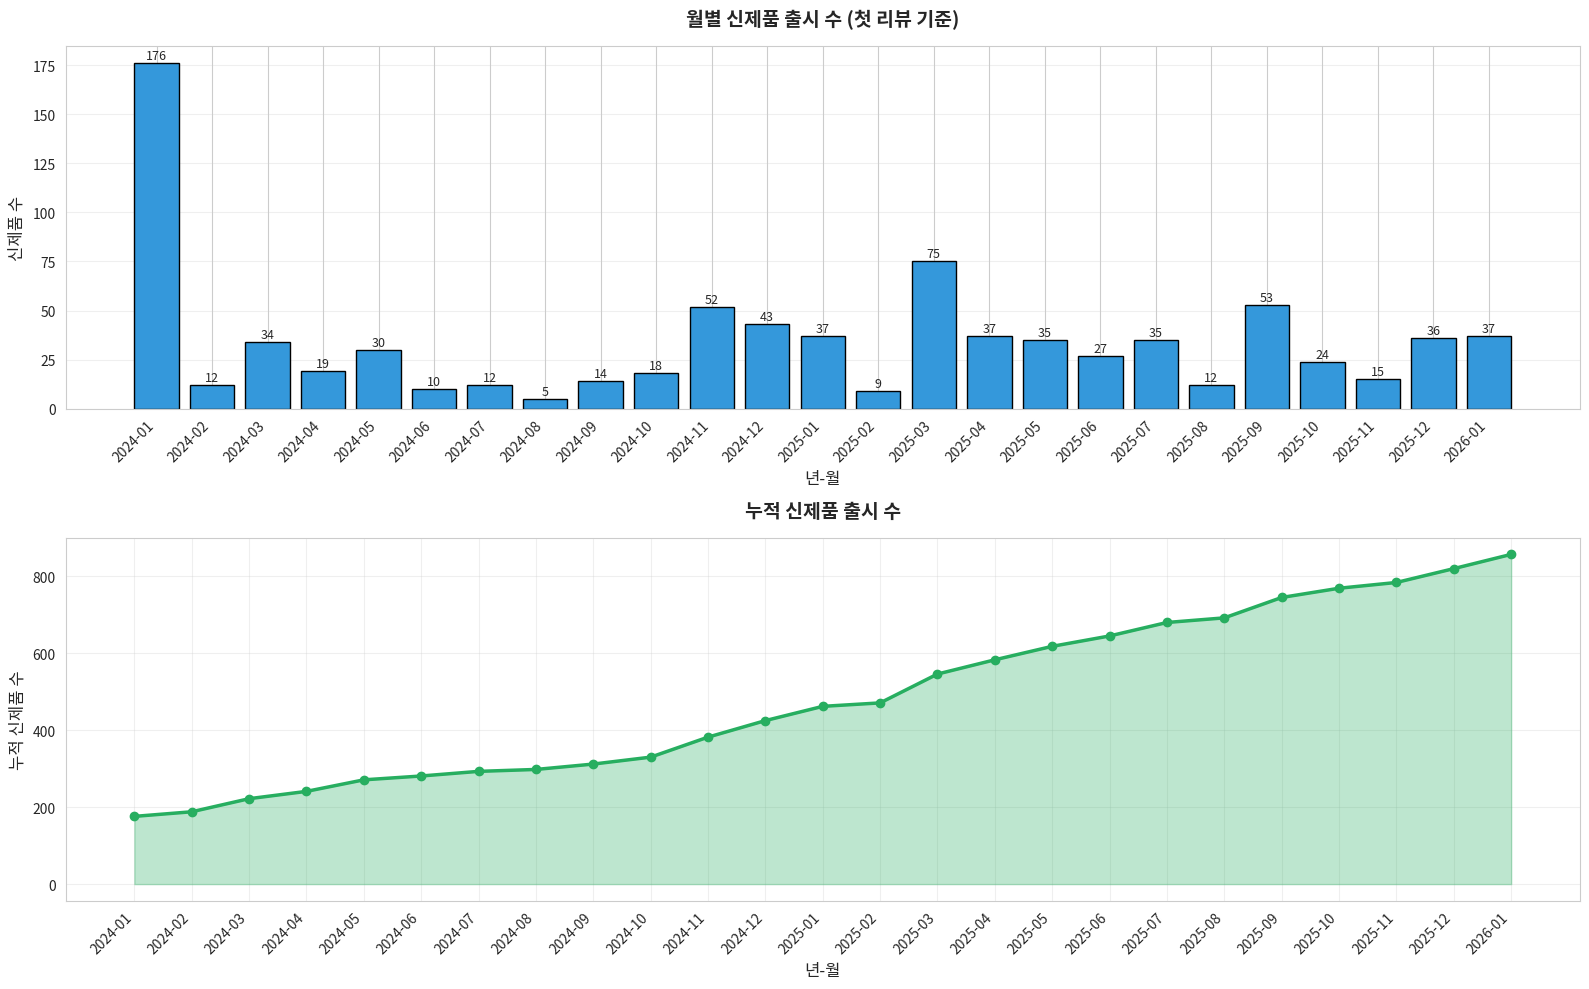

In [ ]:
# 월별 신제품 출시 수
monthly_new_products = product_first_review.groupby('first_review_ym').size()

# 시각화
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# 1. 월별 신제품 출시 수
axes[0].bar(range(len(monthly_new_products)), monthly_new_products.values,
           color='#3498DB', edgecolor='black', linewidth=1)
axes[0].set_xticks(range(len(monthly_new_products)))
axes[0].set_xticklabels(monthly_new_products.index.astype(str), rotation=45, ha='right')
axes[0].set_xlabel('년-월', fontsize=12)
axes[0].set_ylabel('신제품 수', fontsize=12)
axes[0].set_title('월별 신제품 출시 수 (첫 리뷰 기준)', fontsize=14, fontweight='bold', pad=15)
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(monthly_new_products.values):
    axes[0].text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=9)

# 2. 누적 신제품 수
cumulative_new_products = monthly_new_products.cumsum()

axes[1].plot(range(len(cumulative_new_products)), cumulative_new_products.values,
            marker='o', color='#27AE60', linewidth=2.5, markersize=6)
axes[1].fill_between(range(len(cumulative_new_products)), 0, cumulative_new_products.values,
                     color='#27AE60', alpha=0.3)
axes[1].set_xticks(range(len(cumulative_new_products)))
axes[1].set_xticklabels(cumulative_new_products.index.astype(str), rotation=45, ha='right')
axes[1].set_xlabel('년-월', fontsize=12)
axes[1].set_ylabel('누적 신제품 수', fontsize=12)
axes[1].set_title('누적 신제품 출시 수', fontsize=14, fontweight='bold', pad=15)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

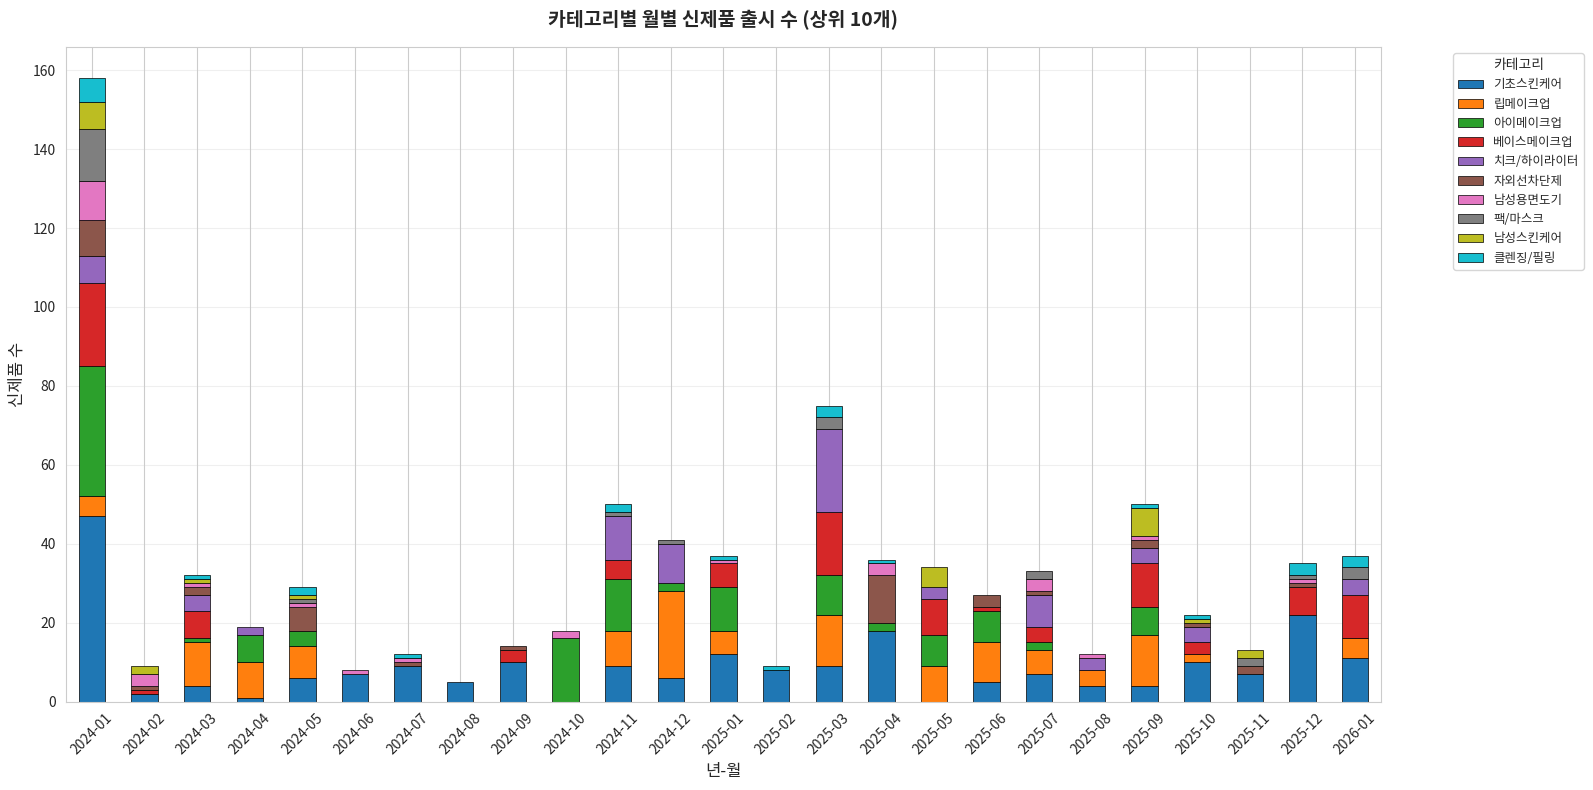

In [18]:
# 카테고리별 신제품 출시 패턴
category_monthly_new = product_first_review.groupby(['first_review_ym', 'category_2']).size().unstack(fill_value=0)

# 상위 10개 카테고리
top_10_new_products = category_monthly_new.sum().nlargest(10).index

# 시각화
fig, ax = plt.subplots(figsize=(16, 8))

category_monthly_new[top_10_new_products].plot(kind='bar', stacked=True, ax=ax,
                                                colormap='tab10', edgecolor='black', linewidth=0.5)

ax.set_xlabel('년-월', fontsize=12)
ax.set_ylabel('신제품 수', fontsize=12)
ax.set_title('카테고리별 월별 신제품 출시 수 (상위 10개)', fontsize=14, fontweight='bold', pad=15)
ax.legend(title='카테고리', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
# 최근 출시된 신제품 (최근 3개월)
recent_3_months = pd.Period('2025-11', freq='M')  # 예시
recent_new_products = product_first_review[
    product_first_review['first_review_ym'] >= recent_3_months
].sort_values('first_review_date', ascending=False)

print(f"=== 최근 3개월 신제품 (2025년 11월 이후) ===")
print(f"총 {len(recent_new_products)}개\n")

for idx, row in recent_new_products.head(20).iterrows():
    print(f"[{row['first_review_date'].strftime('%Y-%m-%d')}] {row['name']}")
    print(f"  카테고리: {row['category_2']} | 브랜드: {row['brand']} | Engagement: {row['engagement_score']:.1f}")
    print()

=== 최근 3개월 신제품 (2025년 11월 이후) ===
총 88개

[2026-01-12] [01 페일화이트]밀크터치 디어씽 페이스 컨투어 크림 브라이트너
  카테고리: 치크/하이라이터 | 브랜드: 밀크터치 디어씽 | Engagement: 171.3

[2026-01-12] [03 애플무스]밀크터치 디어씽 글로우 이펙트 젤리 터치팟
  카테고리: 립메이크업 | 브랜드: 밀크터치 디어씽 | Engagement: 99.6

[2026-01-12] [01 피치버니]밀크터치 디어씽 글로우 이펙트 젤리 터치팟
  카테고리: 립메이크업 | 브랜드: 밀크터치 디어씽 | Engagement: 105.8

[2026-01-11] [05 오디퓌레]밀크터치 디어씽 글로우 이펙트 젤리 터치팟
  카테고리: 립메이크업 | 브랜드: 밀크터치 디어씽 | Engagement: 77.2

[2026-01-11] [04 체리드롭]밀크터치 디어씽 글로우 이펙트 젤리 터치팟
  카테고리: 립메이크업 | 브랜드: 밀크터치 디어씽 | Engagement: 67.1

[2026-01-11] [02 베리슈가]밀크터치 디어씽 글로우 이펙트 젤리 터치팟
  카테고리: 립메이크업 | 브랜드: 밀크터치 디어씽 | Engagement: 102.0

[2026-01-11] [02 핑크빔]밀크터치 디어씽 글로우 이펙트 리퀴드 하이라이터
  카테고리: 치크/하이라이터 | 브랜드: 밀크터치 디어씽 | Engagement: 70.6

[2026-01-11] [01 허니빔]밀크터치 디어씽 글로우 이펙트 리퀴드 하이라이터
  카테고리: 치크/하이라이터 | 브랜드: 밀크터치 디어씽 | Engagement: 97.0

[2026-01-11] [02 퓨어레몬]밀크터치 디어씽 페이스 컨투어 크림 브라이트너
  카테고리: 치크/하이라이터 | 브랜드: 밀크터치 디어씽 | Engagement: 423.3

[2026-01-11] 케어존플러스 광채탄력 아이볼세럼 15 ml
  카테고리: 기초스킨케어 | 브랜드: 케어존 플러스 | E